# TP: Building an MLP from Scratch for CIFAR-10 Classification

_Adapted from [Dataflowr Module 5](https://dataflowr.github.io/website/modules/5-stacking-layers/#practicals) by Marc Lelarge_

In this practical, you will implement a Multi-Layer Perceptron (MLP) from scratch using PyTorch to classify images from the CIFAR-10 dataset.

## System Setup

Import the required packages and check PyTorch version.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, datasets
import time

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{torch.__version__=}")
print(f"Using {device=}")

torch.__version__='2.9.0+cu128'
Using device='cuda:0'


## Part 1: Building the Dataset

### About CIFAR-10

CIFAR-10 is a dataset of 32x32 color images in 10 classes:
- **Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- **Training images**: 50,000 (5,000 per class)
- **Test images**: 10,000 (1,000 per class)
- **Image size**: 32x32 pixels, RGB (3 channels)

### Data Preprocessing

For an MLP, we need to:
1. Convert images to tensors
2. Normalize pixel values (mean=0.5, std=0.5 for each channel)
3. Flatten 32x32x3 images into 1D vectors of size 3072

**TODO 1:** Create a transform pipeline using `transforms.Compose` that:
- Converts images to tensors with `transforms.ToTensor()`
- Normalizes with `transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))`

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

### Loading CIFAR-10 Dataset

**TODO 2:** Load the CIFAR-10 dataset using `datasets.CIFAR10`.

Hints:
- Set `root='./data'` to specify download directory
- Set `train=True` for training set, `train=False` for test set
- Set `download=True` to download the dataset
- Use the transform pipeline you created above

Check the documentation: [datasets.CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)

In [5]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


### Check Dataset Properties

**TODO 3:** Print the sizes of training and test datasets, and examine the class names.

In [12]:
print(len(train))
print(len(test))
print(train.classes)

50000
10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Creating DataLoaders

DataLoaders handle batching, shuffling, and parallel loading of data.

**TODO 4:** Create DataLoaders for training and testing.

Hints:
- Use `batch_size=128` for training
- Use `batch_size=100` for testing
- Set `shuffle=True` for training data
- Set `shuffle=False` for test data
- Set `num_workers=2` for parallel data loading

Check the documentation: [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [7]:
from torch.utils.data import DataLoader
loader_train = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)
loader_test = DataLoader(test, batch_size=100, shuffle=False, num_workers=2)

### Visualize Sample Images

**TODO 5:** Visualize a batch of training images using matplotlib.

Hints:
- Get a batch using `next(iter(train_loader))`
- Use `torchvision.utils.make_grid()` to create a grid of images
- Don't forget to denormalize before displaying (reverse the normalization)

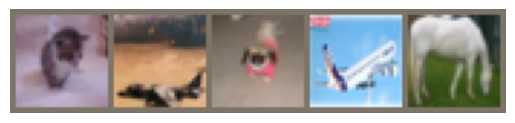

In [19]:
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

images, labels = next(iter(loader_train))

# Create a grid from the first 5 images
grid_first_5 = torchvision.utils.make_grid(images[:5])
imshow(grid_first_5)

## Part 2: Understanding MLP Architecture

### What is an MLP?

A Multi-Layer Perceptron (MLP) is a fully connected neural network consisting of:
- **Input layer**: Takes flattened input (3072 values for 32x32x3 images)
- **Hidden layers**: One or more layers that learn features
- **Output layer**: Produces class probabilities (10 values for CIFAR-10)

### Architecture Design

We will build an MLP with the following structure:

```
Input: 32x32x3 image → Flatten → 3072 values
   ↓
Linear(3072 → 1000)  [Weights: 3072×1000 + 1000 bias = 3,073,000 parameters]
   ↓
ReLU activation
   ↓
Linear(1000 → 10)    [Weights: 1000×10 + 10 bias = 10,010 parameters]
   ↓
Output: 10 class scores
```

**Total parameters**: ~3.08 million

### Understanding Dimensions

Each linear layer performs: `output = input @ weights.T + bias`

For a batch of size B:
- Input shape: `[B, 3072]`
- After first linear: `[B, 1000]`
- After second linear: `[B, 10]`

### Non-Linear Activation Functions

**Why do we need activation functions?**

Without non-linearity, stacking multiple linear layers is equivalent to a single linear layer:
```
Layer1(Layer2(x)) = W1(W2*x + b2) + b1 = (W1*W2)*x + (W1*b2 + b1) = W3*x + b3
```

**ReLU (Rectified Linear Unit)**: `ReLU(x) = max(0, x)`
- Introduces non-linearity
- Computationally efficient
- Helps avoid vanishing gradient problem
- Most commonly used activation function

## Part 3: Building the MLP with PyTorch

### Using nn.Sequential

PyTorch provides `nn.Sequential` to stack layers sequentially. This is convenient for simple architectures.

**TODO 6:** Build the MLP model using `nn.Sequential` with:
1. `nn.Flatten()` - converts [B, 3, 32, 32] to [B, 3072]
2. `nn.Linear(3072, 1000)` - hidden layer
3. `nn.ReLU()` - activation function
4. `nn.Linear(1000, 10)` - output layer

Check the documentation:
- [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

In [28]:

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
)

output = model(images)

print(output)
print(len(output))
print(len(output[0]))

tensor([[ 0.2917,  0.0511,  0.1305,  ...,  0.2597, -0.3752, -0.0044],
        [ 0.0431, -0.2816,  0.1914,  ..., -0.1733, -0.2162,  0.2951],
        [ 0.1853, -0.0385,  0.0353,  ...,  0.1130, -0.2579,  0.1428],
        ...,
        [-0.1479, -0.1364, -0.0629,  ...,  0.1573,  0.1261,  0.1746],
        [-0.4006, -0.2855,  0.0125,  ...,  0.1493,  0.1172, -0.2895],
        [-0.0648, -0.0764,  0.0139,  ..., -0.0404, -0.1485, -0.0226]],
       grad_fn=<AddmmBackward0>)
128
10


### Verify Model Architecture

**TODO 7:** Print the model architecture and count the total number of parameters.

Hints:
- Print the model to see its structure
- Use `sum(p.numel() for p in model.parameters())` to count parameters

In [30]:
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(total_params)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=1000, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1000, out_features=10, bias=True)
)
3083010


### Test Forward Pass

**TODO 8:** Test the model with a random batch to verify dimensions.

Hints:
- Create a random tensor of shape `[4, 3, 32, 32]` (batch of 4 images)
- Pass it through the model
- Verify output shape is `[4, 10]`

In [31]:
rnd = torch.rand(4, 3, 32, 32)
output = model(rnd)
print(output.shape)

torch.Size([4, 10])


## Part 4: Training the MLP

### Loss Function and Optimizer

**Loss Function**: We use Cross-Entropy Loss for multi-class classification
- Combines `LogSoftmax` and `NLLLoss`
- Measures the difference between predicted probabilities and true labels

**Optimizer**: We use Stochastic Gradient Descent (SGD)
- Updates weights in the direction that reduces loss
- Momentum helps accelerate convergence

**TODO 9:** Create the loss function and optimizer.

Hints:
- Use `nn.CrossEntropyLoss()`
- Use `torch.optim.SGD` with:
  - `lr=0.01` (learning rate)
  - `momentum=0.9`
  - `model.parameters()` to optimize all parameters

Check the documentation:
- [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Training Loop

The training loop consists of:
1. **Forward pass**: Compute predictions
2. **Loss computation**: Calculate error
3. **Backward pass**: Compute gradients using `loss.backward()`
4. **Optimizer step**: Update weights using `optimizer.step()`
5. **Zero gradients**: Clear gradients with `optimizer.zero_grad()`

**TODO 10:** Implement the training function.

Hints:
- Set model to training mode: `model.train()`
- Loop over batches from the dataloader
- Move data to device (GPU/CPU)
- Perform forward pass, compute loss, backward pass, optimizer step
- Track running loss and accuracy
- Use `torch.max(outputs, 1)` to get predicted classes

In [36]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * X_batch.size(0)
         # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        total_samples += y_batch.size(0)
        correct_predictions += (predicted == y_batch).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

### Train the Model

**TODO 11:** Train the model for 10 epochs.

Note: Training may take several minutes depending on your hardware.

In [42]:
num_epochs_nn = 100
train_losses_nn = []
test_losses_nn = []

model.to(device) # Move the model to the specified device

for epoch in range(num_epochs_nn):
    train_loss, train_accuracy = train_one_epoch(model, loader_train, loss_fn, optimizer, device)
    train_losses_nn.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs_nn}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

Epoch 1/100, Train Loss: 0.9690, Train Accuracy: 0.6779
Epoch 2/100, Train Loss: 0.9213, Train Accuracy: 0.6970
Epoch 3/100, Train Loss: 0.9069, Train Accuracy: 0.7034
Epoch 4/100, Train Loss: 0.8562, Train Accuracy: 0.7211
Epoch 5/100, Train Loss: 0.8336, Train Accuracy: 0.7302
Epoch 6/100, Train Loss: 0.8225, Train Accuracy: 0.7361
Epoch 7/100, Train Loss: 0.7728, Train Accuracy: 0.7523
Epoch 8/100, Train Loss: 0.7636, Train Accuracy: 0.7590
Epoch 9/100, Train Loss: 0.7189, Train Accuracy: 0.7728
Epoch 10/100, Train Loss: 0.7045, Train Accuracy: 0.7762
Epoch 11/100, Train Loss: 0.6695, Train Accuracy: 0.7899
Epoch 12/100, Train Loss: 0.6873, Train Accuracy: 0.7878
Epoch 13/100, Train Loss: 0.6899, Train Accuracy: 0.7943
Epoch 14/100, Train Loss: 0.6540, Train Accuracy: 0.8037
Epoch 15/100, Train Loss: 0.6593, Train Accuracy: 0.8052
Epoch 16/100, Train Loss: 0.6063, Train Accuracy: 0.8190
Epoch 17/100, Train Loss: 0.6040, Train Accuracy: 0.8239
Epoch 18/100, Train Loss: 0.6496, Train 

## Part 5: Model Evaluation

### Test Function

**TODO 12:** Implement a function to evaluate the model on the test set.

Hints:
- Set model to evaluation mode: `model.eval()`
- Use `torch.no_grad()` to disable gradient computation
- Calculate test loss and accuracy
- Store predictions and probabilities for analysis

In [43]:
def test_fn(model, dataloader, loss_fn, device):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        all_predictions = []
        all_probabilities = []
        all_labels = []

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * X_batch.size(0)

            # Get predicted classes and probabilities
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.softmax(outputs, dim=1)

            total_samples += y_batch.size(0)
            correct_predictions += (predicted == y_batch).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy, all_predictions, all_probabilities, all_labels

### Evaluate on Test Set

**TODO 13:** Run the test function and report accuracy.

In [45]:
test_loss, test_accuracy, _, _, _ = test_fn(model, loader_test, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 12.9687, Test Accuracy: 0.4960


## Next?

What happens if you
- switch the training to a GPU? Is it faster?
- Remove the `ReLU()`?
- Increase the learning rate?
- Stack more layers?
- Perform more epochs?